In [12]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download("punkt")
stop_words = set(stopwords.words('english'))

import tensorflow as tf
import tensorflow_hub as hub
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF, TruncatedSVD, KernelPCA, PCA, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_csv("data.csv")
data_broken = pd.read_csv("data_broken_sub_tags.csv")

len(data), len(data_broken)

(1268, 1488)

## Find similar sentences

In [4]:
# http://agailloty.rbind.io/project/nlp_clean-text/

def clean_text(text):
    """
    This function takes as input a text on which several 
    NLTK algorithms will be applied in order to preprocess it
    """
    # remove new lines
    text = text.replace("\n", " ")
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # tokenize text
    tokens = word_tokenize(text)
    # Remove the punctuations
    # It removes words that have punctuation, e.g non-avian. So not good.
#     tokens = [word for word in tokens if word.isalpha()] 
    # Lower the tokens
    tokens = [word.lower() for word in tokens]
    # Remove stopword
#     tokens = [word for word in tokens if not word in stopwords.words("english")]
    # Lemmatize
#     lemma = WordNetLemmatizer()
#     tokens = [lemma.lemmatize(word, pos = "v") for word in tokens]
#     tokens = [lemma.lemmatize(word, pos = "n") for word in tokens]
    return tokens#' '.join(tokens)

data["normalized"] = data["text"].apply(clean_text)
# data.head(10)

In [5]:
data.head(5)

,Name,Tags,Sub Tags,True or not?,Previous Tags,Comment,paper link,data_source,GPT3 believes?,text,text_len,normalized
0,Central Intelligence Agency was\nresponsible for the assassination of President John F. Kennedy,Conspiracy,Political,False,conspiracy theory paper,NaN,https://chicagounbound.uchicago.edu/law_and_economics/119/,CT papers,NaN,Central Intelligence Agency was responsible for the assassination of President John F. Kennedy.,94,"[central, intelligence, agency, was, responsible, for, the, assassination, of, president, john, f, kennedy]"
1,the 1996 crash of TWA flight 800 was caused by a\nU.S. military missile,Conspiracy,Political,False,conspiracy theory paper,NaN,https://chicagounbound.uchicago.edu/law_and_economics/119/,CT papers,NaN,the 1996 crash of TWA flight 800 was caused by a U.S. military missile.,70,"[the, 1996, crash, of, twa, flight, 800, was, caused, by, a, us, military, missile]"
2,plane crash\nthat killed Democrat Paul Wellstone was engineered by Republican politicians,Conspiracy,Political,False,conspiracy theory paper,NaN,https://chicagounbound.uchicago.edu/law_and_economics/119/,CT papers,NaN,plane crash that killed Democrat Paul Wellstone was engineered by Republican politicians.,88,"[plane, crash, that, killed, democrat, paul, wellstone, was, engineered, by, republican, politicians]"
3,"Martin Luther King, Jr., was killed by federal agents",Conspiracy,Political,False,conspiracy theory paper,NaN,https://chicagounbound.uchicago.edu/law_and_economics/119/,CT papers,NaN,"Martin Luther King, Jr., was killed by federal agents.",53,"[martin, luther, king, jr, was, killed, by, federal, agents]"
4,the\nTrilateral Commission is responsible for important movements of the international\neconomy,Conspiracy,Political,False,conspiracy theory paper,NaN,https://chicagounbound.uchicago.edu/law_and_economics/119/,CT papers,NaN,the Trilateral Commission is responsible for important movements of the international economy.,93,"[the, trilateral, commission, is, responsible, for, important, movements, of, the, international, economy]"


# Find semantic similarity
- word embedding averaging
- sentence embedding
    - SkipThought: an adaptation of the Word2Vec algorithm that produces embeddings by learning to predict the surroundings of an encoded sentence
    - SentenceBERT: based on the popular BERT model, this framework combines the power of transformer architectures and twin neural networks to create high-quality sentence representations
    - InferSent: produces sentence embeddings by training neural networks to identify semantic relationships between sentences in a supervised manner
    - Universal Sentence Encoder (USE): a collection of two models that leverages multi-task learning to encode sentences into highly generic sentence vectors that are easily adaptable for a wide range of NLP tasks
        - One of the most well-performing sentence embedding techniques right now is the Universal Sentence Encoder
    - [Doc2Vec](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py)
        - Le and Mikolov in 2014 introduced the Doc2Vec algorithm, which usually outperforms such simple-averaging of Word2Vec vectors.

## Doc2Vec
https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/

In [13]:
def cosine(u, v):
    # given two vectors, find the cosine similarity
    
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [14]:
## Create tagged dataset
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(data["normalized"])]
# tagged_data[:2]

## Train doc2vec model
'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''
model = Doc2Vec(tagged_data, vector_size = 20, window = 7, min_count = 1, epochs = 150)

In [15]:
test_doc = data["normalized"][0]
print(test_doc)

test_doc_vector = model.infer_vector(test_doc)

# positive = List of sentences that contribute positively.
model.dv.most_similar(positive = [test_doc_vector])

['central', 'intelligence', 'agency', 'was', 'responsible', 'for', 'the', 'assassination', 'of', 'president', 'john', 'f', 'kennedy']


[(0, 0.8984022736549377),
 (349, 0.7346636056900024),
 (60, 0.6933414936065674),
 (344, 0.6916602253913879),
 (66, 0.6847114562988281),
 (771, 0.6760851740837097),
 (453, 0.6740525364875793),
 (723, 0.665217936038971),
 (43, 0.6643721461296082),
 (62, 0.661197304725647)]

In [20]:
# For each sentence in the data, find the 3 top similar senteces and see if they are similar

saved = []

for i, row in data.iterrows():
    text = row["text"]
    tokens = row["normalized"]
    print(text, end="\n\n")
    
    doc_vector = model.infer_vector(tokens)
    similar_docs = model.dv.most_similar(positive = [doc_vector], topn=5)
    ids = [i]
    for doc in similar_docs:
        index, vec = doc
        norm_sent = tagged_data[index][0]
        actual_sent = data.iloc[index]["text"]
        ids.append(index)
        print(index, actual_sent)
    
    ## comment "break" to view more data
    break
    
    save = input()
    if save.lower().startswith("y"):
        saved.append(ids)
    clear_output()

Central Intelligence Agency was responsible for the assassination of President John F. Kennedy.

0 Central Intelligence Agency was responsible for the assassination of President John F. Kennedy.
344 Hillary Clinton participated in the ritual murder of a child.
349 The Government of China is engaged in espionage overseas, directed through diverse methods including cyber espionage to gain access to sensitive information remotely, signals intelligence, human intelligence as well as the exertion of political influence.
453 Julius Caesar was born via caesarean section.
60 The US government covered up crucial information in the aftermath of J. F. Kennedy’s assassination.


## USE (Universal Sentence Encoder)
One of the most well-performing sentence embedding techniques right now is the Universal Sentence Encoder


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)

In [8]:
sentence_embeddings = model(data["text"].tolist())

In [9]:
len(sentence_embeddings)

1268

In [10]:
def top_n_matches(vec, sent_vecs, n=10):
    '''
    Find top n closest sentences to vec
    '''
    scores = []
    for ix, sent_vec in enumerate(sent_vecs):
        cos = cosine(vec, sent_vec)
        scores.append((ix,cos))
    
    return sorted(scores, key=lambda a: np.absolute(a[1]), reverse=True)[:n]

In [245]:
## This saves all similar sentences in a file

with open("simialar_senteces.txt", "w") as f:
    for ix, sent_vec in enumerate(sentence_embeddings):
        top_sents = top_n_matches(sent_vec, sentence_embeddings)

        # show top sentences
#         f.write("\n" + data.iloc[ix]["Name"] + "\n\n")
        f.write("\n\n" + str(ix) + "\n\n")
        for sent in top_sents:
            i, score = sent
            # str(score) + "\t" + 
            f.write(data.iloc[i]["text"] + "\n\n")

# Visualize topics/tags
- https://www.displayr.com/principal-component-analysis-of-text-data/
    - https://canadacentral.displayr.com/Dashboard?project_id=-1005902#page=28d17a05-6a97-4795-b387-4c7c6eb3bdc7

- [Manifold Learning](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold)
    - [Tutorial](https://scikit-learn.org/stable/modules/manifold.html#manifold)
    - [Examples](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py)
- [Matrix Decomposition](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)
- [Discriminant Analysis](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.discriminant_analysis)

Dimensionality reduction:
- **[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)**
    - Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Here we plot the different samples on the 2 first principal components.
    - https://towardsdatascience.com/introduction-to-principal-component-analysis-pca-with-python-code-69d3fcf19b57
        - https://github.com/DhruvilKarani/PCA-blog-notebook/blob/master/PCA.ipynb
- **[tSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE)**
    - [More manifold methods](https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py)
- **[KenelPCA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html#sphx-glr-auto-examples-decomposition-plot-kernel-pca-py)**
- **[SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)**
- [Factory Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html#sklearn.decomposition.FactorAnalysis): Like PCA but the vectors are not necessarily orthogonal
- **[LDA](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py)**: Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.
- **[NCA](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py)**: Neighborhood Components Analysis (NCA) tries to find a feature space such that a stochastic nearest neighbor algorithm will give the best accuracy. Like LDA, it is a supervised method.

Topic Extraction:
- [NMF](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
    - [Topic Extraction](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)
- Latent Dirichlet Analysis
    - [Topic Extraction](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py)



- Clustering:
    - [Kmeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
    - [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)
    - [Optics](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS)

### Features from text
- [tf-idf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)
- [vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
- [word embedding averaging](https://www.geeksforgeeks.org/python-word-embedding-using-word2vec/)
- [sentence embedding](https://www.taus.net/resources/blog/what-are-sentence-embeddings-and-their-applications)
    - SkipThought: an adaptation of the Word2Vec algorithm that produces embeddings by learning to predict the surroundings of an encoded sentence
    - SentenceBERT: based on the popular BERT model, this framework combines the power of transformer architectures and twin neural networks to create high-quality sentence representations
    - InferSent: produces sentence embeddings by training neural networks to identify semantic relationships between sentences in a supervised manner
    - Universal Sentence Encoder (USE): a collection of two models that leverages multi-task learning to encode sentences into highly generic sentence vectors that are easily adaptable for a wide range of NLP tasks
    - Doc2Vec
    
    
### See These:
- https://github.com/zalandoresearch/fashion-mnist
- https://cs.uwaterloo.ca/~jianzhao/cs889/docs/exercises.html#vd2

## PCA

In [11]:
len(sentence_embeddings), len(sentence_embeddings[0])

(1268, 512)

In [256]:
pca = PCA(n_components = 2)
  
pca_emb = pca.fit_transform(sentence_embeddings)
  
explained_variance = pca.explained_variance_ratio_

explained_variance*100

array([4.99392552, 3.05082485])

<AxesSubplot: >

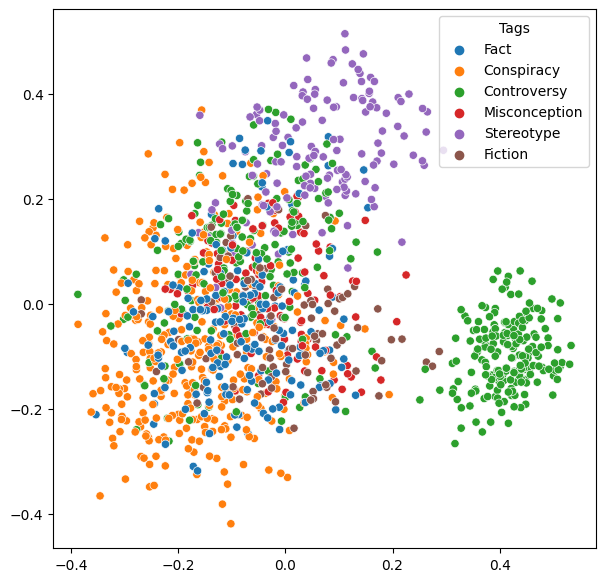

In [267]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=pca_emb[:,0], y=pca_emb[:,1], hue=data["Tags"])

<AxesSubplot: >

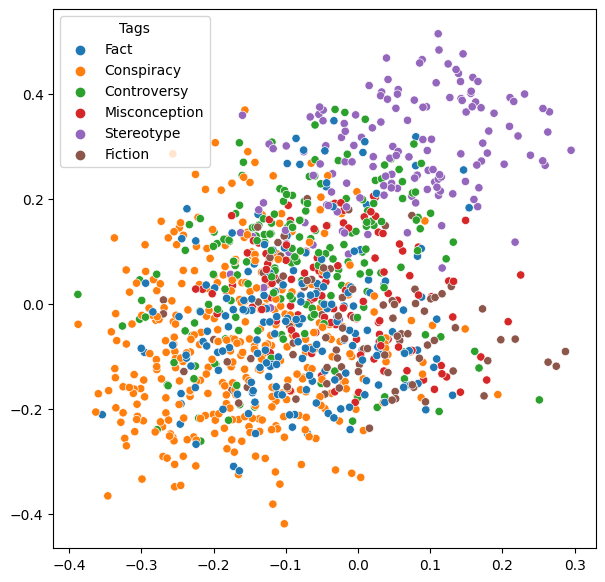

In [279]:
## Excude opinion from plot

opinion_ix = data[data["Sub Tags"]=="Opinion"].index.tolist()
mask = [True if i not in opinion_ix else False for i in data.index.tolist()]

plt.figure(figsize=(7,7))
sns.scatterplot(x=pca_emb[mask,0], y=pca_emb[mask,1], hue=data.loc[mask,"Tags"])

## tSNE

/home/a2khatun/.venv/grs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/a2khatun/.venv/grs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot: >

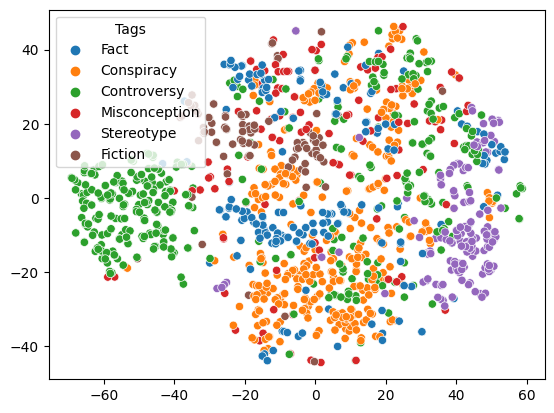

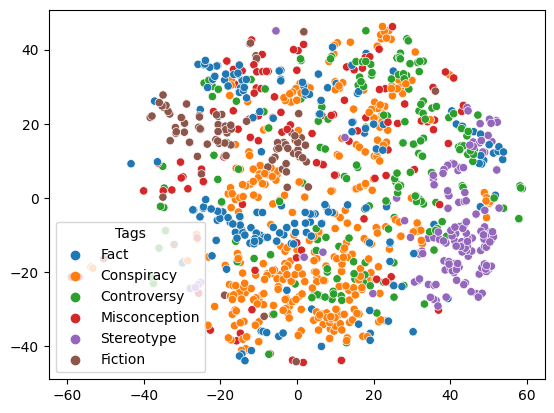

In [312]:
tsne = TSNE(n_components=2)
tsne_emb = tsne.fit_transform(sentence_embeddings)

# plt.figure(figsize=(7,7))
plt.figure()
sns.scatterplot(x=tsne_emb[:,0], y=tsne_emb[:,1], hue=data["Tags"])

## Without opinions
# plt.figure(figsize=(7,7))
plt.figure()
sns.scatterplot(x=tsne_emb[mask,0], y=tsne_emb[mask,1], hue=data.loc[mask,"Tags"])

/home/a2khatun/.venv/grs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot: >

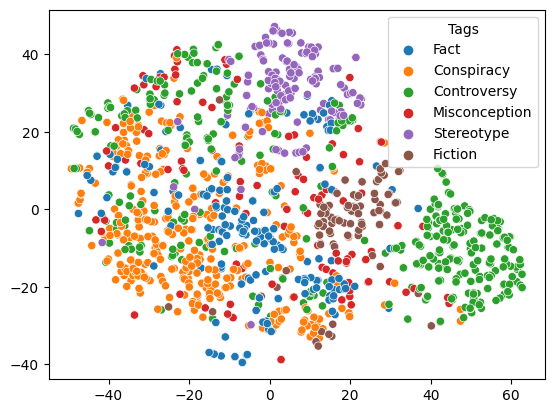

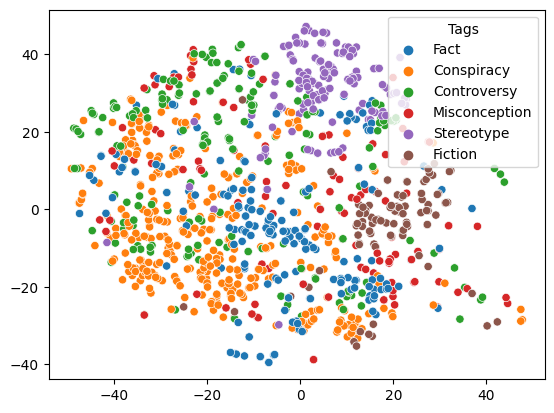

In [313]:
tsne_emb = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(sentence_embeddings)

# plt.figure(figsize=(7,7))
plt.figure()
sns.scatterplot(x=tsne_emb[:,0], y=tsne_emb[:,1], hue=data["Tags"])

## Without opinions
# plt.figure(figsize=(7,7))
plt.figure()
sns.scatterplot(x=tsne_emb[mask,0], y=tsne_emb[mask,1], hue=data.loc[mask,"Tags"])

## Kernel PCA

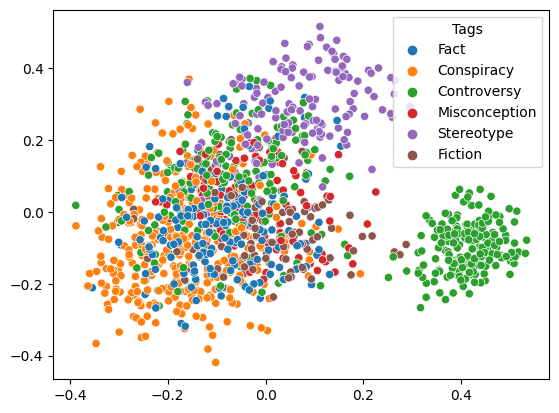

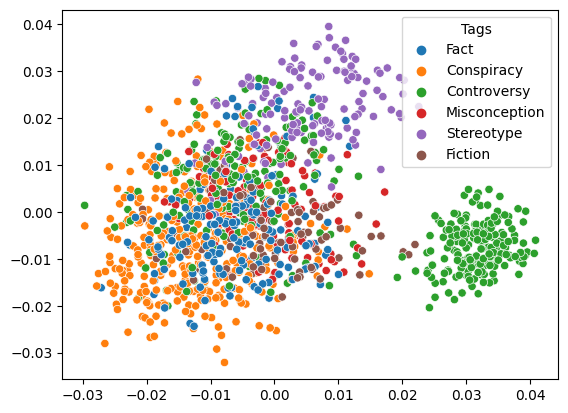

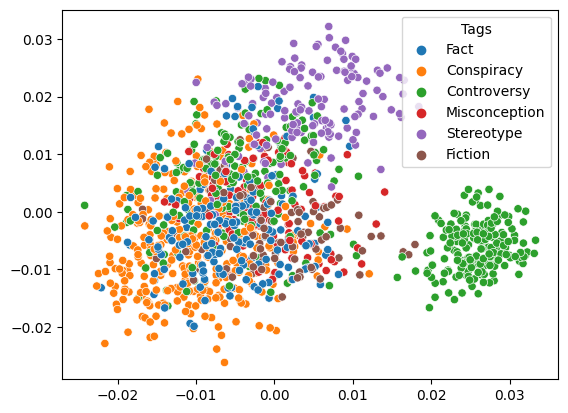

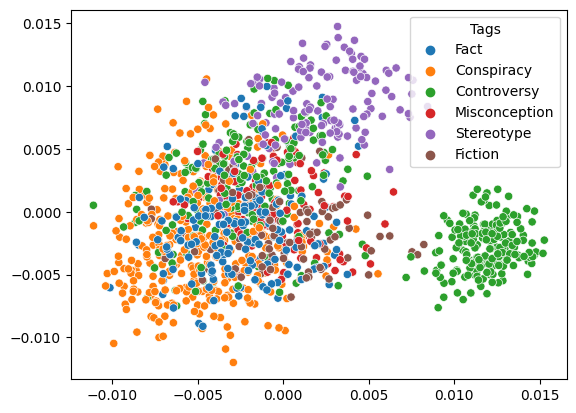

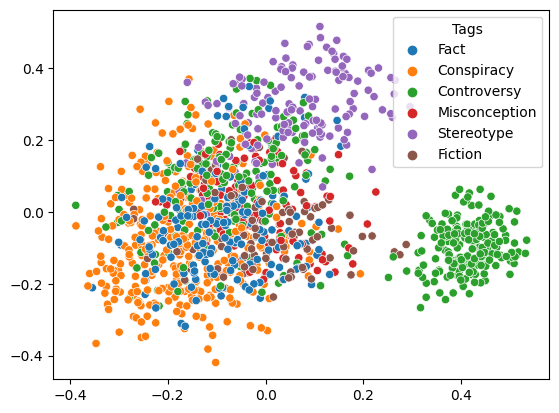

In [314]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']

for kernel in kernels:
    kpca = KernelPCA(n_components=7, kernel=kernel)
    kpca_emb = kpca.fit_transform(sentence_embeddings)
    plt.figure()
    sns.scatterplot(x=kpca_emb[:,0], y=kpca_emb[:,1], hue=data["Tags"])

## SVD
- When truncated SVD is applied to term-document matrices (as returned by CountVectorizer or TfidfVectorizer), this transformation is known as **latent semantic analysis (LSA)**, because it transforms such matrices to a “semantic” space of low dimensionality.

[1.0022063 4.992656 ]


<AxesSubplot: >

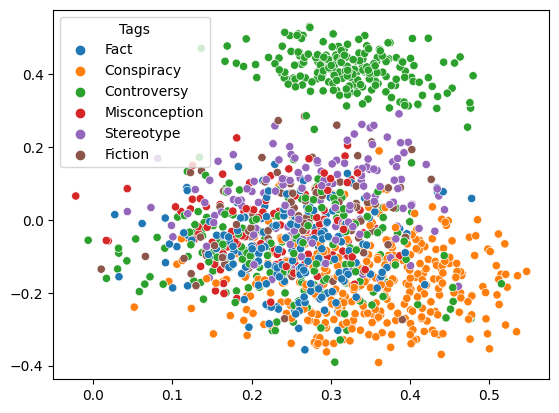

In [338]:
svd = TruncatedSVD(n_components=2, n_iter=5)
svd_emb = svd.fit_transform(sentence_embeddings)

print(svd.explained_variance_ratio_*100)

plt.figure()
sns.scatterplot(x=svd_emb[:,0], y=svd_emb[:,1], hue=data["Tags"])

## Factory Analysis

<AxesSubplot: >

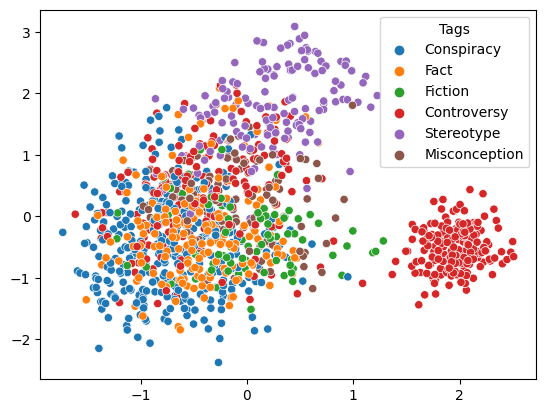

In [13]:
fa = FactorAnalysis(n_components=2)
fa_emb = fa.fit_transform(sentence_embeddings)

plt.figure()
sns.scatterplot(x=fa_emb[:,0], y=fa_emb[:,1], hue=data["Tags"])

## Neighbourhood Components Analysis (NCA)

Neighborhood Component Analysis (NCA) is a machine learning algorithm for metric learning. It learns a linear transformation in a supervised fashion to improve the classification accuracy of a stochastic nearest neighbors rule in the transformed space.

Neighborhood Components Analysis (NCA, NeighborhoodComponentsAnalysis) is a distance metric learning algorithm which aims to improve the accuracy of nearest neighbors classification compared to the standard Euclidean distance. The algorithm directly maximizes a stochastic variant of the leave-one-out k-nearest neighbors (KNN) score on the training set. It can also learn a low-dimensional linear projection of data that can be used for data visualization and fast classification. 

NCA can be used to perform supervised dimensionality reduction. The input data are projected onto a linear subspace consisting of the directions which minimize the NCA objective.

- https://scikit-learn.org/stable/modules/neighbors.html#neighborhood-components-analysis
- https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py

Comparison:

- Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data.

- Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

- Neighborhood Components Analysis (NCA) tries to find a feature space such that a stochastic nearest neighbor algorithm will give the best accuracy. Like LDA, it is a supervised method.

<AxesSubplot: >

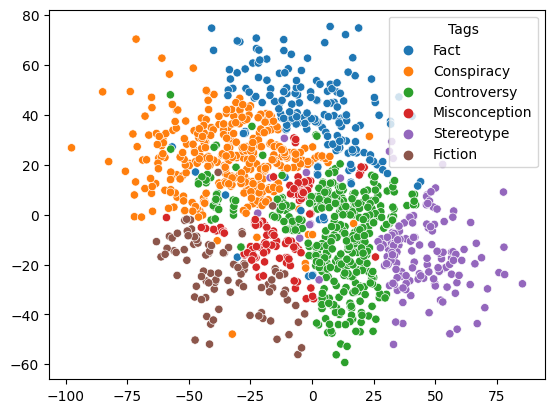

In [317]:
# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = NeighborhoodComponentsAnalysis(n_components=2)
nca_emb = nca.fit_transform(sentence_embeddings, data["Tags"])

plt.figure()
sns.scatterplot(x=nca_emb[:,0], y=nca_emb[:,1], hue=data["Tags"])

## Linear Discriminant Analysis (LDA)

- [Example](https://scikit-learn.org/stable/auto_examples/neighbors/plot_nca_dim_reduction.html#sphx-glr-auto-examples-neighbors-plot-nca-dim-reduction-py)
- [LDA](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)

<AxesSubplot: >

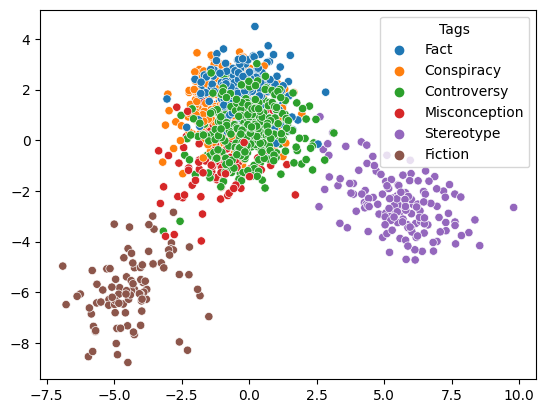

In [322]:
lda = LinearDiscriminantAnalysis(n_components=2)
lda_emb = lda.fit_transform(sentence_embeddings, data["Tags"])
plt.figure()
sns.scatterplot(x=lda_emb[:,0], y=lda_emb[:,1], hue=data["Tags"])

## Manifold Embedding
- [Examples](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py)
- [Tutorial](https://scikit-learn.org/stable/modules/manifold.html#manifold)

In [42]:
X = sentence_embeddings.numpy().copy()
y = data["Tags"]

n_samples, n_features = X.shape
n_neighbors = 30

X.shape, y.shape

((1268, 512), (1268,))

In [43]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.manifold import (
    Isomap,
    LocallyLinearEmbedding,
    MDS,
    SpectralEmbedding,
    TSNE,
)
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.random_projection import SparseRandomProjection

embeddings = {
    "Random projection embedding": SparseRandomProjection(
        n_components=2, random_state=42
    ),
    "Truncated SVD embedding": TruncatedSVD(n_components=2),
    "Linear Discriminant Analysis embedding": LinearDiscriminantAnalysis(
        n_components=2
    ),
    "Isomap embedding": Isomap(n_neighbors=n_neighbors, n_components=2),
    "Standard LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="standard"
    ),
    "Modified LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="modified"
    ),
    "Hessian LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="hessian"
    ),
    "LTSA LLE embedding": LocallyLinearEmbedding(
        n_neighbors=n_neighbors, n_components=2, method="ltsa"
    ),
    "MDS embedding": MDS(
        n_components=2, n_init=1, max_iter=120, n_jobs=2
    ),
    "Random Trees embedding": make_pipeline(
        RandomTreesEmbedding(n_estimators=200, max_depth=5, random_state=0),
        TruncatedSVD(n_components=2),
    ),
    "Spectral embedding": SpectralEmbedding(
        n_components=2, random_state=0, eigen_solver="arpack"
    ),
    "t-SNE embeedding": TSNE(
        n_components=2,
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
    "NCA embedding": NeighborhoodComponentsAnalysis(
        n_components=2, init="pca", random_state=0
    ),
}

In [44]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        ara = X.copy()
        ara += 0.01  # Make X invertible #.flat[:: ara.shape[1] + 1]
    else:
        ara = X

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(ara, y)
    timing[name] = time() - start_time

Computing Random projection embedding...
Computing Truncated SVD embedding...
Computing Linear Discriminant Analysis embedding...
Computing Isomap embedding...
Computing Standard LLE embedding...
Computing Modified LLE embedding...
Computing Hessian LLE embedding...
Computing LTSA LLE embedding...
Computing MDS embedding...
Computing Random Trees embedding...
Computing Spectral embedding...
Computing t-SNE embeedding...


/home/a2khatun/.venv/grs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/a2khatun/.venv/grs/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Computing NCA embedding...


# Topic Modeling

## NMF

NMF is an alternative approach to decomposition that assumes that the data and the components are non-negative.
- https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

See this to extract topic words. Will need to do tfidf I think.
https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45

In [48]:
from time import time
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, MiniBatchNMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10  # number of topics
n_top_words = 20
batch_size = 128
init = "nndsvda"


topic_models = {
    "NMF model (Frobenius norm)": NMF(
        n_components=n_components,
        random_state=1,
        init=init,
        beta_loss="frobenius",
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=0,
    ),
    "NMF model (KL divergence)": NMF(
        n_components=n_components,
        random_state=1,
        init=init,
        beta_loss="kullback-leibler",
        solver="mu",
        max_iter=1000,
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=0.5,
    ),
    "MiniBatchNMF model (Frobenius norm)": MiniBatchNMF(
        n_components=n_components,
        random_state=1,
        batch_size=batch_size,
        init=init,
        beta_loss="frobenius",
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=0.5,
    ),
    "MiniBatchNMF model (KL divergence)": MiniBatchNMF(
        n_components=n_components,
        random_state=1,
        batch_size=batch_size,
        init=init,
        beta_loss="kullback-leibler",
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=0.5,
    ),
    "LDA": LatentDirichletAllocation(
        n_components=n_components,
        max_iter=5,
        learning_method="online",
        learning_offset=50.0,
        random_state=0,
    )

}


def get_tfidf(data):
    # Use tf-idf features for NMF.
    # Words occurring in only one document or in at least 95% of the documents are removed
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(
        lowercase=True, max_df=0.95, min_df=2, max_features=n_features, stop_words="english",
    )
    tfidf = tfidf_vectorizer.fit_transform(data)
    return tfidf_vectorizer, tfidf


def get_tf(data):
    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(
        lowercase=True, max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
    )
    tf = tf_vectorizer.fit_transform(data)
    return tf_vectorizer, tf

In [50]:
text = data["text"].tolist()

tfidf_vectorizer, tfidf = get_tfidf(text)
tf_vectorizer, tf = get_tf(text)

Extracting tf-idf features for NMF...
Extracting tf features for LDA...


In [54]:
func = topic_models["NMF model (Frobenius norm)"]

In [57]:
topics = func.fit(tfidf)
feature_names = tfidf_vectorizer.get_feature_names_out()

In [63]:
topics

NMF(alpha_H=5e-05, alpha_W=5e-05, init='nndsvda', l1_ratio=0, n_components=10,
    random_state=1)

In [62]:
topics.components_.shape

(10, 1000)

In [66]:
feature_names[:20]

array(['000', '11', '19', '2010', '2010s', '2011', '2012', '2014', '2015',
       '2016', '2017', '2018', '2020', '2021', 'able', 'abortion',
       'abuse', 'access', 'accident', 'account'], dtype=object)

In [ ]:
for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1: -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

In [68]:
topics.transform(tfidf).shape

(1268, 10)

In [71]:
topicW = topics.transform(tfidf)

In [97]:
topicW

array([[1.58402552e-03, 1.48114677e-02, 0.00000000e+00, ...,
        3.43938036e-02, 6.25185994e-03, 0.00000000e+00],
       [9.60849279e-05, 7.47714529e-03, 0.00000000e+00, ...,
        5.13048838e-02, 8.76557228e-03, 0.00000000e+00],
       [1.35098018e-03, 3.16147260e-03, 0.00000000e+00, ...,
        6.53490897e-03, 3.54749222e-03, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.36435202e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.80121162e-03, 4.54579651e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.92762459e-04, 1.03221169e-03, 0.00000000e+00]])

In [88]:
topicW.sum(axis=1)

array([0.0706637 , 0.07443171, 0.02868418, ..., 0.0483556 , 0.00663699,
       0.00132497])

In [78]:
topicW.sum(axis=1).shape

(1268,)

In [100]:
summ = np.tile(topicW.sum(axis=1), (10, 1)).T
perc = topicW*100.0/summ
perc[:10]

/tmp/ipykernel_949508/1433244122.py:2: RuntimeWarning: invalid value encountered in divide
  perc = topicW*100.0/summ


array([[ 2.24163969, 20.96050433,  0.        ,  0.        ,  0.        ,
         0.        , 19.27799195, 48.67252085,  8.84734318,  0.        ],
       [ 0.12909138, 10.04564434,  0.        ,  0.        ,  0.27920808,
         8.84059787,  0.        , 68.92879513, 11.77666319,  0.        ],
       [ 4.70984433, 11.02165967,  0.        , 29.67659113,  0.        ,
         0.        , 19.44221082, 22.78227642, 12.36741763,  0.        ],
       [ 6.55919182, 30.85121857,  2.39616181,  9.86141779,  8.04418333,
         9.63023404,  3.15975456, 29.49783809,  0.        ,  0.        ],
       [ 0.        , 21.87452734,  0.        ,  0.        ,  0.        ,
         0.        , 28.57463248,  0.        , 49.55084018,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 10.00877793,  0.        , 89.99122207,  0.        ],
       [ 0.        , 35.19247203,  0.55209564, 55.73116672,  4.00474131,
         0.        ,  0.        ,  0.        

In [101]:
len(data)

1268

## LatentDirichletAllocation
When LatentDirichletAllocation is applied on a “document-term” matrix, the matrix will be decomposed into a “topic-term” matrix and a “document-topic” matrix. While “topic-term” matrix is stored as components_ in the model, “document-topic” matrix can be calculated from transform method.
- https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py